In [1]:
import http.client
import json
import requests
import pandas as pd
# from pandas.io.json import json_normalize 
import numpy as np
import matplotlib.pyplot as plt
from transformers import DistilBertTokenizer, DistilBertModel, DistilBertForSequenceClassification
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
# from pandas.io.json._table_schema import build_table_schema
import torch
import re
# import tensorflow as tf


# Try attention pooling, maybe clean up the descs a bit, and then that's it

https://d2l.ai/chapter_attention-mechanisms-and-transformers/attention-pooling.html

https://stackoverflow.blog/2023/11/09/an-intuitive-introduction-to-text-embeddings/

https://www.reddit.com/r/LanguageTechnology/comments/st1si5/averaging_sentence_embeddings_to_create/


In [2]:
# #notes but with code

# #grabbing name of pattern for searching
# #searching by permalink should easily give me the pattern id, permalink is just last part of url
# search = 'https://www.ravelry.com/patterns/library/oslo-hat-5'
# permalink = search.split('/')[-1]
# permalink

<h1>API Access</h1>

In [3]:
#gives me personal access
authUsername = 	'39589cfb8dbfa66f26be148b1f5dc17a'
authPassword = 'bXzsSC457MZAKS4KLqFUq-GC139GBWbKtzsxFU1k'
baseurl = 'https://api.ravelry.com'

<h1>URL Extraction</h1>

<h3>FIRST I NEED TO FIGURE OUT HOW TO GET PATTERN ID FROM URL</h3>

The plan is to follow what chat gpt says and also look at github repo I found for anything extra. Looks like the other used K-Nearest Neighbors classification?

In [4]:
#first thing i need to do is somehow turn a url into a pattern...

In [5]:
#am I able to search by permalink? like is there a better way to ensure i get the right pattern with provided link?

In [6]:
#replacing permalink with pattern id gives same result!

use pattern descriptions, but if there is no description we need to use other things to feed into the SLM --> I should look at the GitHub repos I found for help!

In [7]:
class ravutils:
    def __init__(self, authUsername, authPassword):
        self.authUsername = authUsername
        self.authPassword = authPassword
        
    def pattern_search(self, query = '',  page = 1, page_size = 100, craft = 'knitting'):
        #returns dataframe
        #remember to search by permalink to get an exact result
        url = baseurl + f'/patterns/search.json?query={query}&page={page}&page_size={page_size}&craft={craft}'
        response = requests.get(url, auth = requests.auth.HTTPBasicAuth(self.authUsername, self.authPassword))
        response.close()
        norm = response.json()['patterns']
        df = pd.json_normalize(data = norm)
        return df
        
    def patternid_search(self, idlist):
        #returns dataframe 
        stridlist = [str(i) for i in idlist]
        idstring = ''
        plus = '+'
        
        if len(idlist) == 1:
            idstring += stridlist[0]
        else:
            idstring = plus.join(stridlist)
        url = baseurl + f'/patterns.json?ids={idstring}'
        response = requests.get(url, auth = requests.auth.HTTPBasicAuth(self.authUsername, self.authPassword))
        response.close()

        norm = response.json()['patterns'].values()
        df = pd.json_normalize(data = norm)

        cols = []
        count = 1
        for column in df.columns:
            if 'name' in column:
                cols.append(f'name_{count}')
                count+=1
                continue
            cols.append(column)
        df.columns = cols 
        return df
        
    def get_id(self, url):
        pass
        
    def get_favorites(self, rav_username = 'khadarty', types = 'pattern', query = '', deep_search = '', page = 1, page_size = 100):
        #gets list of pattern favorites
        url = baseurl + f"/people/{rav_username}/favorites/list.json?types={types}&query={query}&deep_search={deep_search}&page={page}&page_size={page_size}"
        response= requests.get(url, auth = requests.auth.HTTPBasicAuth(self.authUsername, self.authPassword))
        response.close()
        
        norm = response.json()['favorites']
        df = pd.json_normalize(data = norm)
        return df
    def get_queue(self, rav_username = 'khadarty', query = '', page = 1, page_size = 100):
        #define URL
        url = baseurl + f'/people/{rav_username}/queue/list.json?query={query}&page={page}&page_size={page_size}' 
        #make the request
        response = requests.get(url, auth=requests.auth.HTTPBasicAuth(self.authUsername, self.authPassword))
        #close the connection
        response.close()
        norm = response.json()['queued_projects']
        df = pd.json_normalize(data = norm)
        return df
    def get_user(self, rav_username = 'khadarty'):
        #define URL
        url = baseurl + f'/people/{rav_username}.json' 
        #make the request
        response = requests.get(url, auth=requests.auth.HTTPBasicAuth(self.authUsername, self.authPassword))
        #close the connection
        response.close()
        norm = response.json()['user']
        df = pd.json_normalize(data = norm)
        return df
    def get_projects(self, rav_username = 'khadarty', page = 1, page_size = 100, collections = '', sort = ''):
        #define URL
        url = baseurl + f'/projects/{rav_username}/list.json?page={page}&page_size={page_size}&sort={sort}&include={collections}' 
        #make the request
        response = requests.get(url, auth=requests.auth.HTTPBasicAuth(self.authUsername, self.authPassword))
        #close the connection
        response.close()
        norm = response.json()['projects']
        df = pd.json_normalize(data = norm)
        return df
    # def getpattern_notes(self, idlist): #right now this just works for one pattern
    #     #searching for pattern with id search
    #     description = self.patternid_search(idlist)['notes']
    #     return description 

In [8]:
#allowing me to see all rows and columns in a dataframe
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [9]:
#creating instance of thingy thing 
meep = ravutils(authUsername, authPassword)

In [10]:
meep.get_user(rav_username = 'khadarty')

,fave_curse,first_name,id,location,username,tiny_photo_url,small_photo_url,photo_url,large_photo_url,about_me,about_me_html,user_sites
0,,,11835251,,khadarty,None,None,None,None,<3,\n<p>&lt;3</p>\n,[]


In [11]:
meep.get_projects(rav_username = 'khadarty')

,comments_count,completed,craft_id,created_at,favorites_count,id,made_for,made_for_user_id,name,pattern_id,permalink,progress,project_status_changed,project_status_id,rating,size,started,updated_at,user_id,pattern_name,craft_name,status_name,tag_names,first_photo,photos_count,ends_per_inch,picks_per_inch,gauge,row_gauge,gauge_repeats,gauge_divisor,gauge_pattern,completed_day_set,started_day_set,links.self.href,first_photo.id,first_photo.sort_order,first_photo.user_id,first_photo.x_offset,first_photo.y_offset,first_photo.square_url,first_photo.medium_url,first_photo.thumbnail_url,first_photo.small_url,first_photo.medium2_url,first_photo.small2_url,first_photo.caption,first_photo.caption_html,first_photo.copyright_holder
0,0,None,2,2024/10/10 20:12:18 -0400,0,35300358,Friend ﹤3,None,Hipster Hat,799982,hipster-hat,None,2024/10/10 20:12:18 -0400,1,NaN,Man,None,2024/10/10 20:26:41 -0400,11835251,Hipster Hat,Knitting,In progress,[],NaN,0,None,None,29,32,None,4,"ribbing (k2, p2)",False,False,https://www.ravelry.com/projects/khadarty/hips...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,None,2,2024/07/06 13:31:39 -0400,0,34780870,Myself,None,Ophelia Blouse,7303612,ophelia-blouse,None,2024/07/06 13:31:39 -0400,1,3.0,3,None,2024/07/06 13:53:39 -0400,11835251,Ophelia Blouse,Knitting,In progress,[],NaN,1,None,None,24,36,None,4,stockinette,False,False,https://www.ravelry.com/projects/khadarty/ophe...,131146690.0,1.0,11835251.0,-22.0,0.0,https://images4-g.ravelrycache.com/uploads/kha...,https://images4-f.ravelrycache.com/uploads/kha...,https://images4-g.ravelrycache.com/uploads/kha...,https://images4-f.ravelrycache.com/uploads/kha...,https://images4-a.ravelrycache.com/uploads/kha...,https://images4-g.ravelrycache.com/uploads/kha...,NaN,NaN,NaN


In [12]:
# searching for patterns with ids
idsearch1 = meep.patternid_search([523829,7364422,857493])
# getting my favorites, i specified patterns, but you can get all favorites
kdfaves = meep.get_favorites(rav_username = 'khadarty')
# getting ids of my faves
kdfavesid = kdfaves['favorited.id'].values
# getting the notes of all of the patterns in my favorites list by doing an id search
kdfavesnotes = meep.patternid_search(kdfavesid)[['notes']]
#getting my queue
kdqueue = meep.get_queue(rav_username = 'khadarty')
#get ids of queue
kdqueueid = kdqueue['pattern_id'].values
#getting notes of queue patterns 
kdqueuenotes = meep.patternid_search(kdqueueid)[['notes']]


watch these:

https://www.youtube.com/watch?v=v_mONWiFv0k

https://www.youtube.com/watch?v=30zPz5Xz-8g


also this: https://medium.com/coinmonks/how-to-implement-a-recommendation-system-with-deep-learning-and-pytorch-2d40476590f9


https://medium.com/rahasak/recommendation-system-with-content-based-filtering-500231e31a60 //

https://medium.com/coinmonks/how-to-implement-a-recommendation-system-with-deep-learning-and-pytorch-2d40476590f9

https://medium.com/@varun.tyagi83/a-dive-into-reinforcement-learning-and-distilbert-for-movie-recommendations-ab38bd01a8e6

https://medium.com/analytics-vidhya/recommendation-system-using-bert-embeddings-1d8de5fc3c56




In [13]:
#so  basically I just take all of the text 

### Should get patterns in queue, in favorites, and in projects

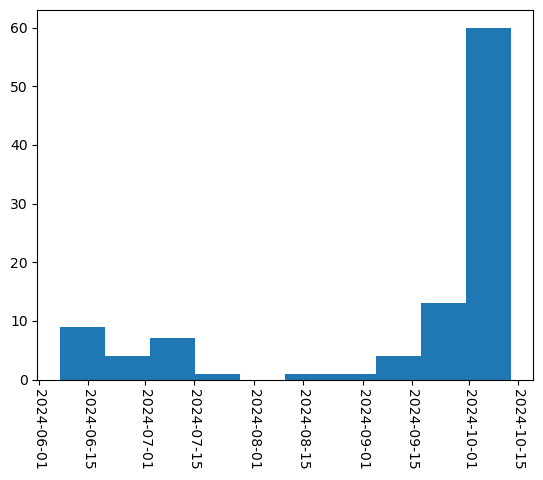

In [14]:
#i could plot the number of favorited patterns over time --> i should figure out how to do date
#bar graph of favorites by pattern type (although i'm struggling to find pattern type)
#I have 83 things in my favorites

#converting strings to datetime objects, plotting histogram of dates --> shows how many patterns i favorited every months
kdfaves['datetime'] = pd.to_datetime(kdfaves['created_at'], errors='coerce', utc = True)
kdfaves['datetime']
kdfaves['date'] = kdfaves['datetime'].dt.date
kdfaves['month'] = kdfaves['datetime'].dt.month
plt.hist(kdfaves['date'])
plt.xlabel('')
plt.xticks(rotation = 270)
plt.show()

<h1>Pattern Data Preprocessing</h1>

should also add stuff from queue and projects and stuff!!

https://www.reddit.com/r/LanguageTechnology/comments/st1si5/averaging_sentence_embeddings_to_create/

is this a good idea?

In [20]:
#my favorites (stuff to train on)
kdfaves_train = meep.patternid_search(kdfavesid)
#pattern_pool --> first start with just a few patterns, about 1000 patterns...
patt_pool1 = meep.pattern_search(page = 5, page_size = 1000)
poolidsearch = meep.patternid_search(patt_pool1['id'].values)


<!-- i removed author name bc it kepy giving me weird shit -->

In [22]:
# import re

# # Original string
# text = "Hello, 123! This is a test: Привет, 世界."

# # Define a pattern to keep only Roman alphabet characters, punctuation, and spaces
# cleaned_text = re.sub(r'[^a-zA-Z\s\.,!?;:]', '', text)

# print(cleaned_text)


In [23]:
#REMEMBER TO REMOVE THE URLS -------------------------->



def dropcols_cleannotes(new_df):
    
    # def rmbracurls(dfcol):
    #     if isinstance(text, str):
    #         url_patt = re.compile(r'\[\d+\]:\s*(https?://\S+|www\.\S+)')
    #         return url_patt.sub('', dfcol)
    #     else:
    #         return text
    def rmurls(text):
        if isinstance(text, str):
            #removing urls, [1]:, and non english characters from text 
            #i'm gonna have to hard code special characters r'[^a-zA-Z\s\.,!?;:]' --> so i'll leave this out for now
            patterns = [r'\[\d+\]:', r'https?://\S+|www\.\S+', r'\[\d+\]']
            combined_pattern = '|'.join(patterns)
            cleaned_text = re.sub(combined_pattern, '', text)
            # url_patt = re.compile(r'https?://\S+|www\.\S+')
            return cleaned_text
        else:
            return ''
    #I can change the columns i need to keep later
    #pattern author permalink and pattern author notes might also be useful at some point also yarn_weight_description
    #11 columns in finished df
    # new_df = df.drop(['created_at', 'currency', 'generally_available', 'has_uk_terminology', 'permalink', 'pdf_url', 
    #             'published', 'updated_at', 'url', 'unlisted_product_ids', 'currency_symbol', 'volumes_in_library', 
    #             'pattern_needle_sizes', 'notes_html', 'languages', 'packs', 'printings', 'pattern_categories', 'pattern_attributes',
    #            'photos', 'download_location.type', 'download_location.free', 'download_location.url', 'yarn_weight.crochet_gauge', 'yarn_weight.knit_gauge',
    #            'yarn_weight.wpi', 'yarn_weight.ply', 'craft.permalink', 'pattern_author.permalink', 'pattern_author.notes', 'pattern_author.notes_html', 
    #                   'pattern_author.users', 'pattern_type.permalink', 'yarn_weight_description', 'has_us_terminology'],  axis = 1)
    
    new_df['notes'] = new_df['notes'].str.replace('\r', ' ').str.replace('\n', ' ').str.replace('*', ' ').str.replace('>', ' ') #i removed '#' from this list
    # new_df['notes'] = new_df['notes'].apply(rmbracurls)
    new_df['notes'] = new_df['notes'].apply(rmurls)
    new_df['combo'] = new_df['gauge_pattern'] + ' ' + new_df['name_1'] + ' ' + new_df['sizes_available'] + ' ' + new_df['gauge_description'] + ' ' + new_df['yardage_description'] + ' ' + new_df['notes'] + ' ' + new_df['name_2'] + ' ' + new_df['name_3'] + ' '  + new_df['name_5'] 
    # + new_df['name_4'] + ' '
    return new_df


In [24]:
non_string_mask = ~poolidsearch['notes'].apply(isinstance, args = (str, ))
non_string_values = poolidsearch[non_string_mask]
non_string_values['notes']

Series([], Name: notes, dtype: object)

In [25]:
#I honestly don't need to select 'object columns'
kdfaves_train = kdfaves_train.fillna('')
poolidsearch = poolidsearch.fillna('')
ftr = dropcols_cleannotes(kdfaves_train)
ptr = dropcols_cleannotes(poolidsearch)


In [26]:
kdfaves_train.iloc[[40]]['yardage_description']

40    185 - 233 yards
Name: yardage_description, dtype: object

In [27]:
ftr['notes'][22], ftr['combo'][22]

('An easy top-down jumper with wide three-quarter sleeves',
 'Stockinette Margit Jumper XS-S (S-M) M-L (L-XL) XL-XXL 10 stitches and 17 rows = 4 inches in Stockinette  yards An easy top-down jumper with wide three-quarter sleeves  Knitting Pullover')

### (then i can move on to in queue and projects)

<h3>Generate user id</h3>

<h1>Loading and Embedding Data Using SLM</h1>

### I just have to stack to include everything 
<br>

https://medium.com/@neri.vvo/how-to-combine-numerical-text-features-10-ways-in-ml-and-dl-5f0ee1b23632#:~:text=Feature%20Concatenation%3A,algorithm%20for%20training%20and%20prediction.

<br>

Follow this tutorial ---> i can just one hot encode categorical features, drop the un-one hot encoded features, and then loop through features and stack them!!!

<br>

I should also check to see if averaging the user features before cosine similarity is a good idea

## Feeding into DistilBERT

In [28]:
# tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased',do_lower_case = True)
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertModel.from_pretrained('distilbert-base-uncased')

/Users/khadarty/miniconda3/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [29]:
# tokenizing first description
text = ptr.iloc[0].combo
tokens = tokenizer.tokenize(text)

In [30]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertModel.from_pretrained('distilbert-base-uncased')

#torch.tensor(tokenids).unsqueeze(0) --> what does this do?
#tokenizing pattern descriptions and feeding them into the model?
def get_embeddings(descriptions):
    # if isinstance(descriptions,str):
    inputs = tokenizer(descriptions, return_tensors="pt", truncation=True, padding=True) #, max_length=128
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1)
    # else:
    #     return descriptions

# Create embeddings for each pattern
pattern_embeddings = [get_embeddings(desc) for desc in ptr['combo']]
user_embeddings = [get_embeddings(desc) for desc in ftr['combo']]

# I need to figure out how to handle Nans in the notes column --> should i just tokenize them?

In [31]:
# import re

# def remove_urls(text):
#     # Define the regex pattern to match URLs
#     url_pattern = re.compile(r'https?://\S+|www\.\S+')
#     # Substitute URLs with an empty string
#     return url_pattern.sub('', text)

# # Example usage
# text_with_urls = "Check this out: https://example.com and also visit www.anotherexample.com"
# clean_text = remove_urls(text_with_urls)
# print(clean_text)

In [32]:
# print(np.shape(user_embeddings), np.shape(pattern_embeddings))

In [33]:
uemb = torch.mean(torch.stack(user_embeddings), dim=0)

#take the average using this and then do cosine similarity

In [34]:
ftr['embeddings'] = user_embeddings
ptr['embeddings'] = pattern_embeddings

## Basically the more preprocessing the higher the performance...

<h1>Comparing Input with Other Patterns</h1>

In [35]:
from sklearn.metrics.pairwise import cosine_similarity
sim_score = []

for i in ptr.embeddings:
    score = cosine_similarity(uemb, i)
    sim_score = np.append(sim_score, score)

ptr['similarity_score'] = sim_score

In [36]:
ptr.head(5).sort_values('similarity_score', ascending = False)

,comments_count,created_at,currency,difficulty_average,difficulty_count,downloadable,favorites_count,free,gauge,gauge_divisor,gauge_pattern,generally_available,has_uk_terminology,has_us_terminology,id,name_1,pdf_url,permalink,price,projects_count,published,queued_projects_count,rating_average,rating_count,row_gauge,updated_at,url,yardage,yardage_max,yarn_list_type,sizes_available,product_id,unlisted_product_ids,currency_symbol,ravelry_download,pdf_in_library,volumes_in_library,gauge_description,yarn_weight_description,yardage_description,pattern_needle_sizes,notes_html,notes,languages,packs,printings,pattern_categories,pattern_attributes,photos,personal_attributes.favorited,personal_attributes.bookmark_id,personal_attributes.queued,personal_attributes.in_library,download_location.type,download_location.free,download_location.url,yarn_weight.crochet_gauge,yarn_weight.id,yarn_weight.knit_gauge,yarn_weight.max_gauge,yarn_weight.min_gauge,name_2,yarn_weight.ply,yarn_weight.wpi,craft.id,name_3,craft.permalink,pattern_author.crochet_pattern_count,pattern_author.favorites_count,pattern_author.id,pattern_author.knitting_pattern_count,name_4,pattern_author.patterns_count,pattern_author.permalink,pattern_author.notes,pattern_author.notes_html,pattern_author.users,pattern_type.clothing,pattern_type.id,name_5,pattern_type.permalink,download_location,combo,embeddings,similarity_score
0,77,2007/02/13 12:22:57 -0500,USD,1.818069,7283.0,True,31216,True,20.0,4.0,"2x2 Rib, lightly stretched",2006/12/01 00:00:00 -0500,,,88,Calorimetry,,calorimetry,,19774,2006/12/01,7787,4.231315,6623.0,22.0,2022/08/29 17:36:00 -0400,http://www.knitty.com/ISSUEwinter06/PATTcalori...,93.0,,1.0,,,[],$,False,False,[],"20 stitches and 22 rows = 4 inches in 2x2 Rib,...",Aran (8 wpi),93 yards,"[{'id': 8, 'us': '8 ', 'metric': 5.0, 'us_stee...",\n<p>Description from Knitty.com:</p>\n\n<bloc...,Description from Knitty.com: Calorimetry is...,"[{'code': 'en', 'id': 1, 'name': 'English', 'p...","[{'id': 468, 'primary_pack_id': None, 'project...","[{'created_at': '2007/11/27 01:14:50 -0500', '...","[{'id': 403, 'name': 'Headband', 'permalink': ...","[{'id': 3, 'permalink': 'unisex'}, {'id': 9, '...","[{'id': 2458, 'sort_order': 1, 'user_id': 1, '...",False,,False,False,external,True,http://www.knitty.com/ISSUEwinter06/PATTcalori...,,1.0,18,,,Aran,10,8,2,Knitting,knitting,0,52,57,1,Kathryn Schoendorf,1,kathryn-schoendorf,,,[],True,3,Hat,hat,,"2x2 Rib, lightly stretched Calorimetry 20 sti...","[[tensor(-0.0685), tensor(-0.0746), tensor(0.2...",0.920403
3,3,2007/05/12 03:05:00 -0400,USD,2.056790,810.0,False,2591,False,20.0,4.0,stockinette stitch,2020/09/08 16:50:30 -0400,,,2983,#10 Kid's Fruit Cap,,10-kids-fruit-cap,,2638,,327,4.525815,736.0,,2021/06/17 13:47:48 -0400,,150.0,200.0,1.0,,637500.0,[],$,True,False,[],20 stitches = 4 inches in stockinette stitch,Worsted (9 wpi),150 - 200 yards,"[{'id': 6, 'us': '6 ', 'metric': 4.0, 'us_stee...",\n<p>This pattern is currently available in pr...,This pattern is currently available in print o...,"[{'code': 'en', 'id': 1, 'name': 'English', 'p...","[{'id': 17113, 'primary_pack_id': None, 'proje...","[{'created_at': '2020/02/12 15:05:54 -0500', '...","[{'id': 413, 'name': 'Beanie, Toque', 'permali...","[{'id': 4, 'permalink': 'baby'}, {'id': 7, 'pe...","[{'id': 91480830, 'sort_order': 1, 'user_id': ...",False,,False,False,,,,,12.0,20,,,Worsted,10,9,2,Knitting,knitting,2,156,853,52,Ann Norling,54,ann-norling,,,[],True,5,Baby,baby,,stockinette stitch #10 Kid's Fruit Cap 20 sti...,"[[tensor(-0.0978), tensor(-0.1185), tensor(0.3...",0.918395
4,54,2007/05/16 11:38:38 -0400,USD,2.354412,2040.0,True,22033,True,28.0,4.0,stockinette stitch,2007/01/01 00:00:00 -0500,,,3417,Norwegian Sweet Baby Cap / Djevellue,,norwegian-sweet-baby-cap---djevellue,,7997,2007/01/01,4145,4.501300,1923.0,,2022/08/08 06:03:12 -0400,http://grosblog.wordpress.com/2007/05/16/sweet...,,,1.0,6 mo (1) 2 yr,,[],$,False,False,[],28 stitches = 4 inches in stockinette stitch,Fin

# Need to change 1/2 to 0.5 ...

<h1>Display Recs</h1>

In [37]:
recs = ptr[['name_1','similarity_score', 'id', 'permalink', 'name_4']]
recs['url'] = 'https://www.ravelry.com/patterns/library/' + recs['permalink']
recs.sort_values('similarity_score', ascending = False).head(30)

/var/folders/yv/z1dch3dj5wx3188lknqcwcc00000gn/T/ipykernel_89806/3498080064.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recs['url'] = 'https://www.ravelry.com/patterns/library/' + recs['permalink']


,name_1,similarity_score,id,permalink,name_4,url
928,Leaf Pile Pullover,0.988068,7368239,leaf-pile-pullover,Triona Murphy,https://www.ravelry.com/patterns/library/leaf-...
26,Zuzu's Petals,0.987085,297373,zuzus-petals,Carina Spencer,https://www.ravelry.com/patterns/library/zuzus...
908,Ammonite sweater,0.986107,7364272,ammonite-sweater,Lyudmila Aksenik,https://www.ravelry.com/patterns/library/ammon...
637,Rustik hat,0.985326,7300891,rustik-hat,Tania Barley,https://www.ravelry.com/patterns/library/rusti...
889,Me Time Sweater,0.984124,7362668,me-time-sweater,SuviKnits,https://www.ravelry.com/patterns/library/me-ti...
379,Eclair,0.983852,1271112,eclair-3,Karin Fernandes,https://www.ravelry.com/patterns/library/eclair-3
498,Cosmo Sweater (Adult),0.983477,1324157,cosmo-sweater-adult,Simone Ryan,https://www.ravelry.com/patterns/library/cosmo...
345,Oh La La Top,0.983323,1246944,oh-la-la-top,Veronika Lindberg,https://www.ravelry.com/patterns/library/oh-la...
982,MY WINTER BOHO,0.983321,7373294,my-winter-boho,NORgardknitters,https://www.ravelry.com/patterns/library/my-wi...
656,Moonflowers Cowl,0.983108,7309312,moonflowers-cowl,Ambah O'Brien,https://www.ravelry.com/patterns/library/moonf...


In [38]:
in_order = recs.sort_values('similarity_score', ascending = False)
in_order['url'].values

array(['https://www.ravelry.com/patterns/library/leaf-pile-pullover',
       'https://www.ravelry.com/patterns/library/zuzus-petals',
       'https://www.ravelry.com/patterns/library/ammonite-sweater',
       'https://www.ravelry.com/patterns/library/rustik-hat',
       'https://www.ravelry.com/patterns/library/me-time-sweater',
       'https://www.ravelry.com/patterns/library/eclair-3',
       'https://www.ravelry.com/patterns/library/cosmo-sweater-adult',
       'https://www.ravelry.com/patterns/library/oh-la-la-top',
       'https://www.ravelry.com/patterns/library/my-winter-boho',
       'https://www.ravelry.com/patterns/library/moonflowers-cowl',
       'https://www.ravelry.com/patterns/library/tuulikki',
       'https://www.ravelry.com/patterns/library/its-got-a-bend-in-it',
       'https://www.ravelry.com/patterns/library/norah-hat-5',
       'https://www.ravelry.com/patterns/library/overskud-2',
       'https://www.ravelry.com/patterns/library/why-knot-3',
       'https://www.r

In [39]:
combined_array = np.column_stack((in_order['url'].values, in_order['similarity_score'].values, in_order['name_4'].values))
np.set_printoptions(threshold=np.inf)
print(combined_array)

[['https://www.ravelry.com/patterns/library/leaf-pile-pullover'
  0.988067626953125 'Triona Murphy']
 ['https://www.ravelry.com/patterns/library/zuzus-petals'
  0.9870851039886475 'Carina Spencer']
 ['https://www.ravelry.com/patterns/library/ammonite-sweater'
  0.9861071705818176 'Lyudmila Aksenik']
 ['https://www.ravelry.com/patterns/library/rustik-hat'
  0.9853264093399048 'Tania Barley']
 ['https://www.ravelry.com/patterns/library/me-time-sweater'
  0.9841237664222717 'SuviKnits']
 ['https://www.ravelry.com/patterns/library/eclair-3' 0.9838518500328064
  'Karin Fernandes']
 ['https://www.ravelry.com/patterns/library/cosmo-sweater-adult'
  0.9834773540496826 'Simone Ryan']
 ['https://www.ravelry.com/patterns/library/oh-la-la-top'
  0.9833230376243591 'Veronika Lindberg']
 ['https://www.ravelry.com/patterns/library/my-winter-boho'
  0.983321487903595 'NORgardknitters']
 ['https://www.ravelry.com/patterns/library/moonflowers-cowl'
  0.9831083416938782 "Ambah O'Brien"]
 ['https://www.ra

In [40]:
#cosine similarity

# maybe get the recommendations, display the image and a summary of the description!!

In [41]:
#printing pattern names and URLs

## Nola

In [42]:
nola = meep.patternid_search(meep.pattern_search(query = 'nola-7')['id'].values)
clean_nola = dropcols_cleannotes(nola)
# clean_nola['combo'].values

In [43]:
from sklearn.metrics.pairwise import cosine_similarity
nola_eb = get_embeddings(clean_nola['combo'][0])
nola_eb


tensor([[-2.5979e-01, -1.3943e-02,  4.4646e-01,  5.4219e-02,  2.7230e-01,
          2.6316e-02,  1.2568e-03,  2.2226e-01, -1.2910e-01, -1.1149e-01,
          7.7060e-05, -3.8697e-01, -1.5479e-01,  2.5361e-01, -1.7061e-01,
          5.2021e-01,  3.2738e-01, -4.7762e-02, -2.0681e-01,  2.2937e-01,
          3.6524e-01, -1.2505e-01,  1.6203e-01,  4.8248e-01,  3.1738e-01,
         -3.8066e-02,  2.3584e-02, -1.3253e-01, -2.7950e-02, -3.3823e-03,
          5.4179e-01, -1.9078e-02,  7.8160e-03, -3.0923e-01,  2.7506e-01,
         -1.1818e-01,  3.1586e-02, -7.4535e-02,  8.2539e-02,  8.2375e-02,
         -3.8767e-01, -1.6405e-01,  3.7152e-02,  1.7261e-02, -1.0538e-01,
         -1.8632e-01,  1.0688e-01,  3.6377e-02, -9.9784e-02, -1.8664e-02,
         -4.6215e-01,  2.2726e-01,  1.6914e-01, -1.2867e-01,  1.9672e-01,
          3.8308e-01, -1.1965e-01, -2.0526e-01, -3.9634e-01, -2.6844e-01,
          6.0682e-02, -9.3231e-03,  2.1773e-01, -7.7030e-02, -1.4249e-01,
         -8.6788e-03, -4.8961e-02,  3.

In [44]:
nola_score = [cosine_similarity(nola_eb,i)[0][0] for i in ptr.embeddings]
ptr['nola_score'] = nola_score
ptr.head()

,comments_count,created_at,currency,difficulty_average,difficulty_count,downloadable,favorites_count,free,gauge,gauge_divisor,gauge_pattern,generally_available,has_uk_terminology,has_us_terminology,id,name_1,pdf_url,permalink,price,projects_count,published,queued_projects_count,rating_average,rating_count,row_gauge,updated_at,url,yardage,yardage_max,yarn_list_type,sizes_available,product_id,unlisted_product_ids,currency_symbol,ravelry_download,pdf_in_library,volumes_in_library,gauge_description,yarn_weight_description,yardage_description,pattern_needle_sizes,notes_html,notes,languages,packs,printings,pattern_categories,pattern_attributes,photos,personal_attributes.favorited,personal_attributes.bookmark_id,personal_attributes.queued,personal_attributes.in_library,download_location.type,download_location.free,download_location.url,yarn_weight.crochet_gauge,yarn_weight.id,yarn_weight.knit_gauge,yarn_weight.max_gauge,yarn_weight.min_gauge,name_2,yarn_weight.ply,yarn_weight.wpi,craft.id,name_3,craft.permalink,pattern_author.crochet_pattern_count,pattern_author.favorites_count,pattern_author.id,pattern_author.knitting_pattern_count,name_4,pattern_author.patterns_count,pattern_author.permalink,pattern_author.notes,pattern_author.notes_html,pattern_author.users,pattern_type.clothing,pattern_type.id,name_5,pattern_type.permalink,download_location,combo,embeddings,similarity_score,nola_score
0,77,2007/02/13 12:22:57 -0500,USD,1.818069,7283.0,True,31216,True,20.0,4.0,"2x2 Rib, lightly stretched",2006/12/01 00:00:00 -0500,,,88,Calorimetry,,calorimetry,,19774,2006/12/01,7787,4.231315,6623.0,22.0,2022/08/29 17:36:00 -0400,http://www.knitty.com/ISSUEwinter06/PATTcalori...,93.0,,1.0,,,[],$,False,False,[],"20 stitches and 22 rows = 4 inches in 2x2 Rib,...",Aran (8 wpi),93 yards,"[{'id': 8, 'us': '8 ', 'metric': 5.0, 'us_stee...",\n<p>Description from Knitty.com:</p>\n\n<bloc...,Description from Knitty.com: Calorimetry is...,"[{'code': 'en', 'id': 1, 'name': 'English', 'p...","[{'id': 468, 'primary_pack_id': None, 'project...","[{'created_at': '2007/11/27 01:14:50 -0500', '...","[{'id': 403, 'name': 'Headband', 'permalink': ...","[{'id': 3, 'permalink': 'unisex'}, {'id': 9, '...","[{'id': 2458, 'sort_order': 1, 'user_id': 1, '...",False,,False,False,external,True,http://www.knitty.com/ISSUEwinter06/PATTcalori...,,1.0,18,,,Aran,10,8,2,Knitting,knitting,0,52,57,1,Kathryn Schoendorf,1,kathryn-schoendorf,,,[],True,3,Hat,hat,,"2x2 Rib, lightly stretched Calorimetry 20 sti...","[[tensor(-0.0685), tensor(-0.0746), tensor(0.2...",0.920403,0.901455
1,9,2007/05/04 12:05:26 -0400,USD,2.643974,1087.0,True,1767,True,,,,2002/07/01 00:00:00 -0400,,,1764,Basic Sock,,basic-sock-18,,7014,2002/07/01,333,4.545370,1069.0,,2020/03/24 13:05:45 -0400,https://www.interweave.com/article/knitting/9-...,200.0,600.0,1.0,,,,$,False,False,[],,,200 - 600 yards,[],\n<p>Patterns in table/grid format for a wide ...,Patterns in table/grid format for a wide varie...,"[{'code': 'en', 'id': 1, 'name': 'English', 'p...","[{'id': 16624, 'primary_pack_id': None, 'proje...","[{'created_at': '2007/11/27 01:14:50 -0500', '...","[{'id': 885, 'name': 'Mid-calf', 'permalink': ...","[{'id': 3, 'permalink': 'unisex'}, {'id': 23, ...","[{'id': 356130, 'sort_order': 1, 'user_id': 27...",False,,False,False,external,True,https://www.interweave.com/article/knitting/9-...,,,,,,,,,2,Knitting,knitting,0,2199,22,295,Ann Budd,295,ann-budd,,,"[{'fave_colors': 'all shades of mud', 'fave_cu...",True,2,Socks,socks,,Basic Sock 200 - 600 yards Patterns in tabl...,"[[tensor(-0.0621), tensor(0.0585), tensor(0.23...",0.908129,0.877591
2,1,2007/05/10 22:39:07 -0400,USD,1.798319,357.0,False,458,False,,,,2020/09/08 16:54:33 -0400,,,2855,#55 Head Huggers,,55-head-huggers,,1605,,82,4.424332,337.0,,2022/07/16 04:55:24 -0400,,,,1.0,,637503.0,[],$,True,False,[],,Any gauge - designed for any gauge,yards,[],\n<p>This pattern includes instructions for 5 ...,This pattern includes instructions for 5 sizes...,"[{'code': 'en',

In [45]:
nola_stuff = ptr.sort_values('nola_score', ascending = False)[['nola_score', 'permalink', 'name_1']]
nola_stuff['url'] = 'https://www.ravelry.com/patterns/library/' + nola_stuff['permalink']
nola_stuff['url'].head(30).values

array(['https://www.ravelry.com/patterns/library/nukunuku-sweater',
       'https://www.ravelry.com/patterns/library/stephenville-crossing',
       'https://www.ravelry.com/patterns/library/newleaf',
       'https://www.ravelry.com/patterns/library/garda',
       'https://www.ravelry.com/patterns/library/third-ave-tee',
       'https://www.ravelry.com/patterns/library/ezra-vest',
       'https://www.ravelry.com/patterns/library/journey-pullover',
       'https://www.ravelry.com/patterns/library/sprinkle-sweater-2',
       'https://www.ravelry.com/patterns/library/evenfall-4',
       'https://www.ravelry.com/patterns/library/effervescent-5',
       'https://www.ravelry.com/patterns/library/mayflower-jumper',
       'https://www.ravelry.com/patterns/library/fresca-top',
       'https://www.ravelry.com/patterns/library/dragon-scales-10',
       'https://www.ravelry.com/patterns/library/whisky-neat',
       'https://www.ravelry.com/patterns/library/meadow-moon',
       'https://www.ravelry

## Nola

In [42]:
nola = meep.patternid_search(meep.pattern_search(query = 'nola-7')['id'].values)
clean_nola = dropcols_cleannotes(nola)
# clean_nola['combo'].values

In [43]:
from sklearn.metrics.pairwise import cosine_similarity
nola_eb = get_embeddings(clean_nola['combo'][0])
nola_eb


tensor([[-2.5979e-01, -1.3943e-02,  4.4646e-01,  5.4219e-02,  2.7230e-01,
          2.6316e-02,  1.2568e-03,  2.2226e-01, -1.2910e-01, -1.1149e-01,
          7.7060e-05, -3.8697e-01, -1.5479e-01,  2.5361e-01, -1.7061e-01,
          5.2021e-01,  3.2738e-01, -4.7762e-02, -2.0681e-01,  2.2937e-01,
          3.6524e-01, -1.2505e-01,  1.6203e-01,  4.8248e-01,  3.1738e-01,
         -3.8066e-02,  2.3584e-02, -1.3253e-01, -2.7950e-02, -3.3823e-03,
          5.4179e-01, -1.9078e-02,  7.8160e-03, -3.0923e-01,  2.7506e-01,
         -1.1818e-01,  3.1586e-02, -7.4535e-02,  8.2539e-02,  8.2375e-02,
         -3.8767e-01, -1.6405e-01,  3.7152e-02,  1.7261e-02, -1.0538e-01,
         -1.8632e-01,  1.0688e-01,  3.6377e-02, -9.9784e-02, -1.8664e-02,
         -4.6215e-01,  2.2726e-01,  1.6914e-01, -1.2867e-01,  1.9672e-01,
          3.8308e-01, -1.1965e-01, -2.0526e-01, -3.9634e-01, -2.6844e-01,
          6.0682e-02, -9.3231e-03,  2.1773e-01, -7.7030e-02, -1.4249e-01,
         -8.6788e-03, -4.8961e-02,  3.

In [44]:
nola_score = [cosine_similarity(nola_eb,i)[0][0] for i in ptr.embeddings]
ptr['nola_score'] = nola_score
ptr.head()

,comments_count,created_at,currency,difficulty_average,difficulty_count,downloadable,favorites_count,free,gauge,gauge_divisor,gauge_pattern,generally_available,has_uk_terminology,has_us_terminology,id,name_1,pdf_url,permalink,price,projects_count,published,queued_projects_count,rating_average,rating_count,row_gauge,updated_at,url,yardage,yardage_max,yarn_list_type,sizes_available,product_id,unlisted_product_ids,currency_symbol,ravelry_download,pdf_in_library,volumes_in_library,gauge_description,yarn_weight_description,yardage_description,pattern_needle_sizes,notes_html,notes,languages,packs,printings,pattern_categories,pattern_attributes,photos,personal_attributes.favorited,personal_attributes.bookmark_id,personal_attributes.queued,personal_attributes.in_library,download_location.type,download_location.free,download_location.url,yarn_weight.crochet_gauge,yarn_weight.id,yarn_weight.knit_gauge,yarn_weight.max_gauge,yarn_weight.min_gauge,name_2,yarn_weight.ply,yarn_weight.wpi,craft.id,name_3,craft.permalink,pattern_author.crochet_pattern_count,pattern_author.favorites_count,pattern_author.id,pattern_author.knitting_pattern_count,name_4,pattern_author.patterns_count,pattern_author.permalink,pattern_author.notes,pattern_author.notes_html,pattern_author.users,pattern_type.clothing,pattern_type.id,name_5,pattern_type.permalink,download_location,combo,embeddings,similarity_score,nola_score
0,77,2007/02/13 12:22:57 -0500,USD,1.818069,7283.0,True,31216,True,20.0,4.0,"2x2 Rib, lightly stretched",2006/12/01 00:00:00 -0500,,,88,Calorimetry,,calorimetry,,19774,2006/12/01,7787,4.231315,6623.0,22.0,2022/08/29 17:36:00 -0400,http://www.knitty.com/ISSUEwinter06/PATTcalori...,93.0,,1.0,,,[],$,False,False,[],"20 stitches and 22 rows = 4 inches in 2x2 Rib,...",Aran (8 wpi),93 yards,"[{'id': 8, 'us': '8 ', 'metric': 5.0, 'us_stee...",\n<p>Description from Knitty.com:</p>\n\n<bloc...,Description from Knitty.com: Calorimetry is...,"[{'code': 'en', 'id': 1, 'name': 'English', 'p...","[{'id': 468, 'primary_pack_id': None, 'project...","[{'created_at': '2007/11/27 01:14:50 -0500', '...","[{'id': 403, 'name': 'Headband', 'permalink': ...","[{'id': 3, 'permalink': 'unisex'}, {'id': 9, '...","[{'id': 2458, 'sort_order': 1, 'user_id': 1, '...",False,,False,False,external,True,http://www.knitty.com/ISSUEwinter06/PATTcalori...,,1.0,18,,,Aran,10,8,2,Knitting,knitting,0,52,57,1,Kathryn Schoendorf,1,kathryn-schoendorf,,,[],True,3,Hat,hat,,"2x2 Rib, lightly stretched Calorimetry 20 sti...","[[tensor(-0.0685), tensor(-0.0746), tensor(0.2...",0.920403,0.901455
1,9,2007/05/04 12:05:26 -0400,USD,2.643974,1087.0,True,1767,True,,,,2002/07/01 00:00:00 -0400,,,1764,Basic Sock,,basic-sock-18,,7014,2002/07/01,333,4.545370,1069.0,,2020/03/24 13:05:45 -0400,https://www.interweave.com/article/knitting/9-...,200.0,600.0,1.0,,,,$,False,False,[],,,200 - 600 yards,[],\n<p>Patterns in table/grid format for a wide ...,Patterns in table/grid format for a wide varie...,"[{'code': 'en', 'id': 1, 'name': 'English', 'p...","[{'id': 16624, 'primary_pack_id': None, 'proje...","[{'created_at': '2007/11/27 01:14:50 -0500', '...","[{'id': 885, 'name': 'Mid-calf', 'permalink': ...","[{'id': 3, 'permalink': 'unisex'}, {'id': 23, ...","[{'id': 356130, 'sort_order': 1, 'user_id': 27...",False,,False,False,external,True,https://www.interweave.com/article/knitting/9-...,,,,,,,,,2,Knitting,knitting,0,2199,22,295,Ann Budd,295,ann-budd,,,"[{'fave_colors': 'all shades of mud', 'fave_cu...",True,2,Socks,socks,,Basic Sock 200 - 600 yards Patterns in tabl...,"[[tensor(-0.0621), tensor(0.0585), tensor(0.23...",0.908129,0.877591
2,1,2007/05/10 22:39:07 -0400,USD,1.798319,357.0,False,458,False,,,,2020/09/08 16:54:33 -0400,,,2855,#55 Head Huggers,,55-head-huggers,,1605,,82,4.424332,337.0,,2022/07/16 04:55:24 -0400,,,,1.0,,637503.0,[],$,True,False,[],,Any gauge - designed for any gauge,yards,[],\n<p>This pattern includes instructions for 5 ...,This pattern includes instructions for 5 sizes...,"[{'code': 'en',

In [45]:
nola_stuff = ptr.sort_values('nola_score', ascending = False)[['nola_score', 'permalink', 'name_1']]
nola_stuff['url'] = 'https://www.ravelry.com/patterns/library/' + nola_stuff['permalink']
nola_stuff['url'].head(30).values

array(['https://www.ravelry.com/patterns/library/nukunuku-sweater',
       'https://www.ravelry.com/patterns/library/stephenville-crossing',
       'https://www.ravelry.com/patterns/library/newleaf',
       'https://www.ravelry.com/patterns/library/garda',
       'https://www.ravelry.com/patterns/library/third-ave-tee',
       'https://www.ravelry.com/patterns/library/ezra-vest',
       'https://www.ravelry.com/patterns/library/journey-pullover',
       'https://www.ravelry.com/patterns/library/sprinkle-sweater-2',
       'https://www.ravelry.com/patterns/library/evenfall-4',
       'https://www.ravelry.com/patterns/library/effervescent-5',
       'https://www.ravelry.com/patterns/library/mayflower-jumper',
       'https://www.ravelry.com/patterns/library/fresca-top',
       'https://www.ravelry.com/patterns/library/dragon-scales-10',
       'https://www.ravelry.com/patterns/library/whisky-neat',
       'https://www.ravelry.com/patterns/library/meadow-moon',
       'https://www.ravelry

## Same thing but for a single pattern --> sebastian sweater

In [46]:
seb_notes = meep.patternid_search([7364422])['notes'].values

In [47]:
seb_notes[0]

'SKILL LEVEL: Intermediate\r\n\r\nTECHNIQUES USED:\r\nCast on, 1x1 ribbing, stockinette stitch, casting off, picking up stitches, knitting in the round, colour chart reading and intarsia knitting.\r\n\r\nSIZES:\r\nThere are 9 sizes included within the pattern: XS (S) M (L) XL (2X) 3X (4X) 5X.\r\n\r\nBust measurements:\r\nXS: 28-30”\r\nS: 32-34”\r\nM: 36-38”\r\nL: 40-42”\r\nXL: 44-46”\r\n2X: 48-50”\r\n3X: 52-54”\r\n4X: 56-58”\r\n5X: 60-62”\r\n\r\nRECOMMENDED NEEDLES:\r\n4.5mm circular knitting needles (80cm or 100cm)\r\n5mm circular knitting needles 80cm or 100cm)\r\nTapestry needle\r\n\r\nYARN REQUIREMENTS:\r\nYou will hold 1 strand of Aran weight yarn throughout the whole piece (ColourLab 100% British Wool Aran, 100g/166m/182yds).\r\nThis follows the notation XS (S) M (L) XL (2X) 3X (4X) 5X.\r\n• Colour A - Cream - 500g (500g) 500g (600g) 600g (700g) 700g (800g) 800g\r\n• Colour B – Red - All sizes: 50g required\r\n• Colour C – Blue - All sizes: < 50g required\r\n• Colour D – Black (o

In [48]:
seb_note = seb_notes[0].replace('\r', ' ').replace('\n', ' ').replace('*', ' ').replace('#', ' ')

In [49]:
from sklearn.metrics.pairwise import cosine_similarity
seb_eb = get_embeddings(seb_note)

seb_score = [cosine_similarity(seb_eb,i)[0][0] for i in ptr.embeddings]
ptr['seb_score'] = seb_score
ptr.head()

,comments_count,created_at,currency,difficulty_average,difficulty_count,downloadable,favorites_count,free,gauge,gauge_divisor,gauge_pattern,generally_available,has_uk_terminology,has_us_terminology,id,name_1,pdf_url,permalink,price,projects_count,published,queued_projects_count,rating_average,rating_count,row_gauge,updated_at,url,yardage,yardage_max,yarn_list_type,sizes_available,product_id,unlisted_product_ids,currency_symbol,ravelry_download,pdf_in_library,volumes_in_library,gauge_description,yarn_weight_description,yardage_description,pattern_needle_sizes,notes_html,notes,languages,packs,printings,pattern_categories,pattern_attributes,photos,personal_attributes.favorited,personal_attributes.bookmark_id,personal_attributes.queued,personal_attributes.in_library,download_location.type,download_location.free,download_location.url,yarn_weight.crochet_gauge,yarn_weight.id,yarn_weight.knit_gauge,yarn_weight.max_gauge,yarn_weight.min_gauge,name_2,yarn_weight.ply,yarn_weight.wpi,craft.id,name_3,craft.permalink,pattern_author.crochet_pattern_count,pattern_author.favorites_count,pattern_author.id,pattern_author.knitting_pattern_count,name_4,pattern_author.patterns_count,pattern_author.permalink,pattern_author.notes,pattern_author.notes_html,pattern_author.users,pattern_type.clothing,pattern_type.id,name_5,pattern_type.permalink,download_location,combo,embeddings,similarity_score,nola_score,seb_score
0,77,2007/02/13 12:22:57 -0500,USD,1.818069,7283.0,True,31216,True,20.0,4.0,"2x2 Rib, lightly stretched",2006/12/01 00:00:00 -0500,,,88,Calorimetry,,calorimetry,,19774,2006/12/01,7787,4.231315,6623.0,22.0,2022/08/29 17:36:00 -0400,http://www.knitty.com/ISSUEwinter06/PATTcalori...,93.0,,1.0,,,[],$,False,False,[],"20 stitches and 22 rows = 4 inches in 2x2 Rib,...",Aran (8 wpi),93 yards,"[{'id': 8, 'us': '8 ', 'metric': 5.0, 'us_stee...",\n<p>Description from Knitty.com:</p>\n\n<bloc...,Description from Knitty.com: Calorimetry is...,"[{'code': 'en', 'id': 1, 'name': 'English', 'p...","[{'id': 468, 'primary_pack_id': None, 'project...","[{'created_at': '2007/11/27 01:14:50 -0500', '...","[{'id': 403, 'name': 'Headband', 'permalink': ...","[{'id': 3, 'permalink': 'unisex'}, {'id': 9, '...","[{'id': 2458, 'sort_order': 1, 'user_id': 1, '...",False,,False,False,external,True,http://www.knitty.com/ISSUEwinter06/PATTcalori...,,1.0,18,,,Aran,10,8,2,Knitting,knitting,0,52,57,1,Kathryn Schoendorf,1,kathryn-schoendorf,,,[],True,3,Hat,hat,,"2x2 Rib, lightly stretched Calorimetry 20 sti...","[[tensor(-0.0685), tensor(-0.0746), tensor(0.2...",0.920403,0.901455,0.861117
1,9,2007/05/04 12:05:26 -0400,USD,2.643974,1087.0,True,1767,True,,,,2002/07/01 00:00:00 -0400,,,1764,Basic Sock,,basic-sock-18,,7014,2002/07/01,333,4.545370,1069.0,,2020/03/24 13:05:45 -0400,https://www.interweave.com/article/knitting/9-...,200.0,600.0,1.0,,,,$,False,False,[],,,200 - 600 yards,[],\n<p>Patterns in table/grid format for a wide ...,Patterns in table/grid format for a wide varie...,"[{'code': 'en', 'id': 1, 'name': 'English', 'p...","[{'id': 16624, 'primary_pack_id': None, 'proje...","[{'created_at': '2007/11/27 01:14:50 -0500', '...","[{'id': 885, 'name': 'Mid-calf', 'permalink': ...","[{'id': 3, 'permalink': 'unisex'}, {'id': 23, ...","[{'id': 356130, 'sort_order': 1, 'user_id': 27...",False,,False,False,external,True,https://www.interweave.com/article/knitting/9-...,,,,,,,,,2,Knitting,knitting,0,2199,22,295,Ann Budd,295,ann-budd,,,"[{'fave_colors': 'all shades of mud', 'fave_cu...",True,2,Socks,socks,,Basic Sock 200 - 600 yards Patterns in tabl...,"[[tensor(-0.0621), tensor(0.0585), tensor(0.23...",0.908129,0.877591,0.881976
2,1,2007/05/10 22:39:07 -0400,USD,1.798319,357.0,False,458,False,,,,2020/09/08 16:54:33 -0400,,,2855,#55 Head Huggers,,55-head-huggers,,1605,,82,4.424332,337.0,,2022/07/16 04:55:24 -0400,,,,1.0,,637503.0,[],$,True,False,[],,Any gauge - designed for any gauge,yards,[],\n<p>This pattern includes instructions for 5 ...,This pattern includes instructions for

In [50]:
ptr.sort_values('seb_score', ascending = False).head(5)

,comments_count,created_at,currency,difficulty_average,difficulty_count,downloadable,favorites_count,free,gauge,gauge_divisor,gauge_pattern,generally_available,has_uk_terminology,has_us_terminology,id,name_1,pdf_url,permalink,price,projects_count,published,queued_projects_count,rating_average,rating_count,row_gauge,updated_at,url,yardage,yardage_max,yarn_list_type,sizes_available,product_id,unlisted_product_ids,currency_symbol,ravelry_download,pdf_in_library,volumes_in_library,gauge_description,yarn_weight_description,yardage_description,pattern_needle_sizes,notes_html,notes,languages,packs,printings,pattern_categories,pattern_attributes,photos,personal_attributes.favorited,personal_attributes.bookmark_id,personal_attributes.queued,personal_attributes.in_library,download_location.type,download_location.free,download_location.url,yarn_weight.crochet_gauge,yarn_weight.id,yarn_weight.knit_gauge,yarn_weight.max_gauge,yarn_weight.min_gauge,name_2,yarn_weight.ply,yarn_weight.wpi,craft.id,name_3,craft.permalink,pattern_author.crochet_pattern_count,pattern_author.favorites_count,pattern_author.id,pattern_author.knitting_pattern_count,name_4,pattern_author.patterns_count,pattern_author.permalink,pattern_author.notes,pattern_author.notes_html,pattern_author.users,pattern_type.clothing,pattern_type.id,name_5,pattern_type.permalink,download_location,combo,embeddings,similarity_score,nola_score,seb_score
840,22,2024/07/20 11:53:06 -0400,,0.000000,,True,1421,True,16.0,4.0,,2024/07/20 11:53:06 -0400,False,False,7355421,"summer top ""Margarita""",,summer-top-margarita,,23,2024/07/01,114,0.000000,,24.0,2024/07/20 11:55:34 -0400,,219.0,437.0,1.0,S (M) L (XL) XXL - eu size chart,941292.0,,,True,False,[],16 stitches and 24 rows = 4 inches,Aran (8 wpi),219 - 437 yards,"[{'id': 8, 'us': '8 ', 'metric': 5.0, 'us_stee...",\n<p>SIZES: S ( M ) L (XL) XXL</p>\n\n<p>Appro...,SIZES: S ( M ) L (XL) XXL Approximate ches...,"[{'code': 'en', 'id': 1, 'name': 'English', 'p...","[{'id': 124163149, 'primary_pack_id': None, 'p...","[{'created_at': '2024/07/20 11:53:06 -0400', '...","[{'id': 308, 'name': 'Sleeveless Top', 'permal...","[{'id': 10, 'permalink': 'adult'}, {'id': 205,...","[{'id': 131441068, 'sort_order': 1, 'user_id':...",False,,False,False,ravelry,True,http://www.ravelry.com/dls/82234/941292,,1.0,18,,,Aran,10,8,2,Knitting,knitting,0,40,120527,22,Veronika Stoncus,22,veronika-stoncus,,,"[{'fave_colors': 'All colors ', 'fave_curse': ...",True,12,Tank/Camisole,camisole,,"summer top ""Margarita"" S (M) L (XL) XXL - eu ...","[[tensor(-0.1545), tensor(-0.0466), tensor(0.3...",0.978386,0.952959,0.967727
284,3,2021/10/14 01:34:04 -0400,USD,2.724138,29.0,True,1395,False,18.0,4.0,"in stockinette stitch, after blocking.",2022/12/01 00:00:00 -0500,,,1181934,Strata,,strata-12,7.0,128,2022/12/01,131,4.812500,32.0,25.0,2023/09/27 06:40:29 -0400,https://www.labienaimee.com/blogs/news,164.0,191.0,1.0,"1 (2, 3)",821906.0,,$,True,False,[],18 stitches and 25 rows = 4 inches in stockine...,Worsted (9 wpi),164 - 191 yards,"[{'id': 6, 'us': '6 ', 'metric': 4.0, 'us_stee...",\n<p>Inspired by the changing of the seasons a...,Inspired by the changing of the seasons and th...,"[{'code': 'en', 'id': 1, 'name': 'English', 'p...","[{'id': 102079959, 'primary_pack_id': None, 'p...","[{'created_at': '2022/12/01 11:50:01 -0500', '...","[{'id': 413, 'name': 'Beanie, Toque', 'permali...","[{'id': 64, 'permalink': 'ribbed'}, {'id': 181...","[{'id': 107536461, 'sort_order': 1, 'user_id':...",False,,False,False,ravelry,False,http://www.ravelry.com/purchase/tif-handknits-...,,12.0,20,,,Worsted,10,9,2,Knitting,knitting,0,4215,101556,150,Tif Neilan,150,tif-neilan,"Hi, I'm Tif!\r\n\r\nI am a Knitwear and Interi...","\n<p>Hi, I’m Tif!</p>\n\n<p>I am a Knitwear an...","[{'fave_colors': 'Grey, Green, Rust orange, Eg...",True,3,Hat,hat,,"in stockinette stitch, after blocking. Strata ...","[[tensor(-0.2390), tensor(0.0187), tensor(0.37...",0.977992,0.961242,0.966357
239,24,2021/04/16 02:03:43 -04

<h1>Deploy Recommender</h1>

In [51]:
#fastapi or flask